In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_parquet("../data/processed/cleaned_clv_data.parquet")

In [74]:
df.head()

,customer_id,transaction_count,promo_code_used,quantity,total_spent,avg_order_value,first_purchase_date,last_purchase_date,recency,customer_age,payment_method_count,future_spend
0,3,12,11,25,20243575.0,963979.761905,2021-01-10 07:56:00,2021-12-12 12:35:00,19 days 11:24:47.155506,355 days 16:03:43.155506,2,2998828.0
1,8,5,1,9,3237281.0,539546.833333,2021-02-13 09:47:00,2021-12-14 20:12:00,17 days 03:47:20.343009,321 days 14:12:20.343009,2,1521320.0
2,9,3,0,5,3206995.0,641399.000000,2021-06-27 01:51:00,2021-11-08 04:42:00,53 days 19:17:28.578966,187 days 22:08:11.578966,2,906635.0
3,15,1,1,1,127423.0,127423.000000,2021-06-12 04:30:00,2021-06-12 04:30:00,202 days 19:29:17.894960,202 days 19:29:17.894960,1,73320.0
4,18,7,11,16,12794750.0,913910.714286,2021-02-01 17:46:00,2021-11-29 19:50:00,32 days 04:09:01.989711,333 days 06:13:41.989711,2,1980302.0


__We'll take transaction recency only in days, it's easier for our model__

In [75]:
df["recency_days"] = df["recency"].dt.days
df["customer_age_days"] = df["customer_age"].dt.days

df.drop(columns=["recency", "customer_age"], inplace=True)

__We'll convert from Indonesian Rupiah to US dollars for better currency clarity and widely accepted format__

In [76]:
CONVERSION_RATE = 16787.54   # This is the rate as of January 30 2026, can change ofc

df["total_spent"] = (df["total_spent"] / CONVERSION_RATE).round(3)
df["future_spend"] = (df["future_spend"] / CONVERSION_RATE).round(3)
df["avg_order_value"] = (df["avg_order_value"] / CONVERSION_RATE).round(3)


__So we'll do the distribution of future spend values(log transformed to remove outlier effect while keeping 0 spend customers)__

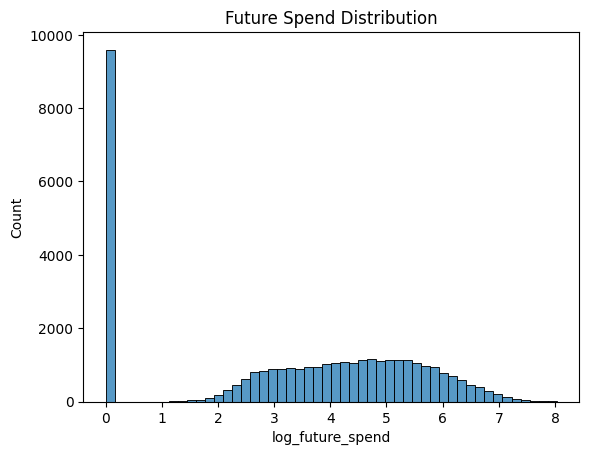

In [77]:
df["log_future_spend"] = np.log1p(df["future_spend"])

plt.figure()
sns.histplot(df["log_future_spend"], bins=50)
plt.title("Future Spend Distribution")
plt.show()

__Grouping buyers and non-buyers based on average transaction activity__

In [78]:
df["will_spend"] = (df["future_spend"] > 0 ).astype(int)

df.groupby("will_spend")[[
    "transaction_count",
    "total_spent",
    "avg_order_value",
    "recency_days",
    "customer_age_days"
]].mean()

,transaction_count,total_spent,avg_order_value,recency_days,customer_age_days
will_spend,,,,,
0,1.281322,135.372706,34.662405,146.737232,212.002502
1,8.789257,916.456833,49.059931,43.578363,279.951117


On average:
+ future spenders make about 8x more transactions
+ And have more recent orders (like 100 days more recent) than those that didn't spend later on

In [79]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 36086 entries, 0 to 36085
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           36086 non-null  int64         
 1   transaction_count     36086 non-null  int64         
 2   promo_code_used       36086 non-null  int64         
 3   quantity              36086 non-null  int64         
 4   total_spent           36086 non-null  float64       
 5   avg_order_value       36086 non-null  float64       
 6   first_purchase_date   36086 non-null  datetime64[us]
 7   last_purchase_date    36086 non-null  datetime64[us]
 8   payment_method_count  36086 non-null  int64         
 9   future_spend          36086 non-null  float64       
 10  recency_days          36086 non-null  int64         
 11  customer_age_days     36086 non-null  int64         
 12  log_future_spend      36086 non-null  float64       
 13  will_spend            36086

In [80]:
df.describe()

,customer_id,transaction_count,promo_code_used,quantity,total_spent,avg_order_value,first_purchase_date,last_purchase_date,payment_method_count,future_spend,recency_days,customer_age_days,log_future_spend,will_spend
count,36086.000000,36086.000000,36086.000000,36086.000000,36086.000000,36086.000000,36086,36086,36086.000000,36086.000000,36086.000000,36086.000000,36086.000000,36086.000000
mean,49763.463476,6.793161,3.599651,14.783545,708.793996,45.232135,2021-04-13 15:07:31.117331,2021-10-21 12:09:50.795322,1.887546,135.517851,71.004683,261.885967,3.293113,0.734135
min,3.000000,1.000000,0.000000,1.000000,1.635000,1.635000,2021-01-01 00:03:00,2021-01-01 01:14:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24718.750000,1.000000,0.000000,2.000000,33.018000,17.049000,2021-01-21 02:02:45,2021-09-21 01:25:30,1.000000,0.000000,12.000000,186.000000,0.000000,0.000000
50%,49669.500000,3.000000,1.000000,6.000000,130.647500,27.521000,2021-03-06 14:58:00,2021-11-24 21:40:00,1.000000,42.775000,37.000000,300.000000,3.779063,1.000000
75%,74789.750000,8.000000,4.000000,18.000000,576.420000,51.549750,2021-06-28 09:30:30,2021-12-19 11:03:00,2.000000,167.486250,101.000000,344.000000,5.126854,1.000000
max,99998.000000,160.000000,101.000000,427.000000,52428.261000,937.057000,2021-12-31 23:07:00,2021-12-31 23:59:00,5.000000,3069.269000,364.000000,364.000000,8.029520,1.000000
std,28962.699742,9.341450,6.059360,21.798400,1759.728243,53.532256,NaN,NaN,1.119340,227.197064,81.951837,97.974154,2.261950,0.441799


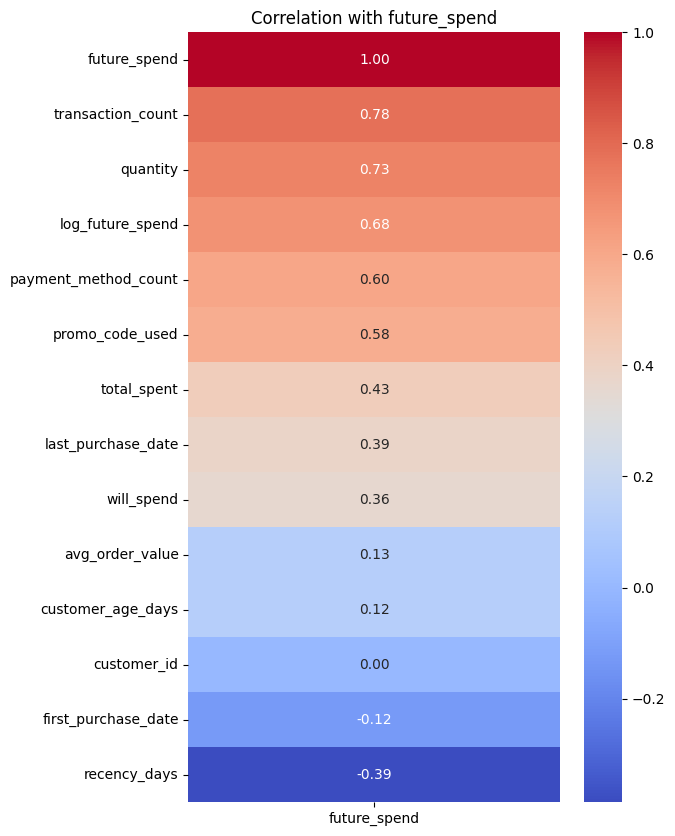

In [81]:

plt.figure(figsize=(6, 10))
sns.heatmap(df.corr()[['future_spend']].sort_values(by='future_spend', ascending=False), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation with future_spend')
plt.show()

__We'll keep the features that our model will be making use of an drop everything else__
+ transaction count
+ quantity
+ number of payment method used
+ number of promo codes used
+ How recent their last purchase was

In [82]:
df = df[["recency_days", "transaction_count", "quantity", "payment_method_count", "promo_code_used", "total_spent", "future_spend"]]
df.head()

,recency_days,transaction_count,quantity,payment_method_count,promo_code_used,total_spent,future_spend
0,19,12,25,2,11,1205.869,178.634
1,17,5,9,2,1,192.838,90.622
2,53,3,5,2,0,191.034,54.006
3,202,1,1,1,1,7.590,4.368
4,32,7,16,2,11,762.158,117.963
